## Gaussian processes and active learning

This notebook explains and constructs a Gaussian Process metamodel for the simulation model using Active learning. It computes the prediction in 400 unlabeled input points.

In [19]:
#Import necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import gpytorch
import torch
from Model import model

In [20]:
###### Load initial data of 200 LHS samples
with open('Data/output200.pickle', 'rb') as handle:
    y = pickle.load(handle)
with open('Data/X200.pickle', 'rb') as handle: #labeled points
    X = pickle.load(handle)


X_labeled = X
y_labeled = y

#Transform datatype to tensors
y_labeled= y_labeled.astype(float)
y_labeled = torch.from_numpy(y_labeled)
X_labeled = torch.from_numpy(X_labeled)

We also need to load 800 LHS sample points in the input space that will define our unlabeled dataset.
This dataset needs to be bigger than the initial labeled dataset.

In [21]:
with open('Data/X800alone.pickle', 'rb') as handle: #unlabeled points
    X_LHS = pickle.load(handle)

X_LHS = torch.from_numpy(X_LHS)


In [22]:
# Define a Gaussian process regression model with GPYtorch
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model1 = GPRegressionModel(X_labeled, y_labeled, likelihood)

In [23]:
# Train the model1 on the labeled dataset
model1.train()
likelihood.train()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model1)

for i in range(500):
    optimizer.zero_grad()
    output = model1(X_labeled)
    loss = -mll(output, y_labeled)
    print(loss)
    loss.backward()
    optimizer.step()

tensor(1194550.4603, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1006478.8928, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(856905.9782, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(737299.6267, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(640901.7035, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(562474.8285, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(498020.1552, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(444510.2947, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(399658.5527, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(361732.6952, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(329411.3257, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(301676.0331, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(277732.4851, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(256953.0975, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(238835.5104, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(222972.6938, dty

In [24]:
#Change the name of the labeled dataset to include more points in the active learning loop
X_new_labeled = X_labeled
y_new_labeled = y_labeled

Now we define the parameters of the Active Learning loop.

In [25]:
#### Active learning loop
n_iter= 100 # number of iterations in the active learning loop
k= 1 # number of elements to query in each loop

In this example, our query criterion will be the entropy of the unlabeled points. The entropy is directly related with the estimated variance and it is measures the informativenss of the data points.

In [26]:
#Function to calculate the entropy given the standard deviation
def entropy_given_normal_std(std_arr):
        """Return entropy given an array of 1D normal standard deviations."""
        entropy = np.log(std_arr) + np.log(np.sqrt(2 * np.pi)) + 0.5
        return entropy

In [27]:
### Active learning loop
for i in range(n_iter):

    # Use the model1 to make predictions on the unlabeled dataset
    model1.eval()
    likelihood.eval()
    with torch.no_grad():
        pred_dist = likelihood(model1(X_LHS))

    # Select the most informative data points using uncertainty sampling
    uncertainty = entropy_given_normal_std(np.sqrt(pred_dist.variance.numpy()))
    uncertainty = torch.from_numpy(uncertainty)
    top_indices = uncertainty.topk(k).indices

    # Compute the value of the new point in the true model
    new_X_point = X_LHS[top_indices,:].numpy()[0]
    new_Y_point = model(new_X_point)

    # Remove the new point from the unlabeled dataset
    X_LHS = X_LHS.numpy()
    X_mask= (X_LHS == new_X_point)
    X_LHS = X_LHS[~X_mask].reshape((-1, 3))
    X_LHS = torch.from_numpy(X_LHS)

   #Update the train datasets with the new point
    new_X_point = np.array([new_X_point])
    new_X_point = torch.from_numpy(new_X_point)
    X_new_labeled = torch.cat([X_new_labeled, new_X_point])
    print('X_new_labeled size: ', X_new_labeled.size())
    print('X_LHS size: ', X_LHS.size())

    y_new_labeled = y_new_labeled.numpy()
    y_new_labeled = np.append(y_new_labeled, new_Y_point)
    y_new_labeled = torch.from_numpy(y_new_labeled)
    print('y_new_labeled size: ', y_new_labeled.size())

    # Re train the model1 on the updated labeled dataset
    model1.set_train_data(X_new_labeled, y_new_labeled, strict=False)
    model1.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model1)

    for i in range(1):
        optimizer.zero_grad()
        output = model1(X_new_labeled)
        loss = -mll(output, y_new_labeled)
        print(loss)
        loss.backward()
        optimizer.step()

X_new_labeled size:  torch.Size([201, 3])
X_LHS size:  torch.Size([799, 3])
y_new_labeled size:  torch.Size([201])
tensor(25690.5342, dtype=torch.float64, grad_fn=<NegBackward0>)
X_new_labeled size:  torch.Size([202, 3])
X_LHS size:  torch.Size([798, 3])
y_new_labeled size:  torch.Size([202])
tensor(25053.0508, dtype=torch.float64, grad_fn=<NegBackward0>)
X_new_labeled size:  torch.Size([203, 3])
X_LHS size:  torch.Size([797, 3])
y_new_labeled size:  torch.Size([203])
tensor(24442.8386, dtype=torch.float64, grad_fn=<NegBackward0>)
X_new_labeled size:  torch.Size([204, 3])
X_LHS size:  torch.Size([796, 3])
y_new_labeled size:  torch.Size([204])
tensor(23881.5138, dtype=torch.float64, grad_fn=<NegBackward0>)
X_new_labeled size:  torch.Size([205, 3])
X_LHS size:  torch.Size([795, 3])
y_new_labeled size:  torch.Size([205])
tensor(23346.2650, dtype=torch.float64, grad_fn=<NegBackward0>)
X_new_labeled size:  torch.Size([206, 3])
X_LHS size:  torch.Size([794, 3])
y_new_labeled size:  torch.Si

In [28]:
with open('Data/X400.2.pickle', 'rb') as handle:
   X_unlabeled = pickle.load(handle)

X_unlabeled = torch.from_numpy(X_unlabeled)

In [29]:
#Get the final value of the posterior for the another LHS samples
model1.eval()
likelihood.eval()
print('Final loss:',loss)

with torch.no_grad():
    pred_dist = likelihood(model1(X_unlabeled))

pred_dist

Final loss: tensor(6519.1791, dtype=torch.float64, grad_fn=<NegBackward0>)


MultivariateNormal(loc: torch.Size([400]))

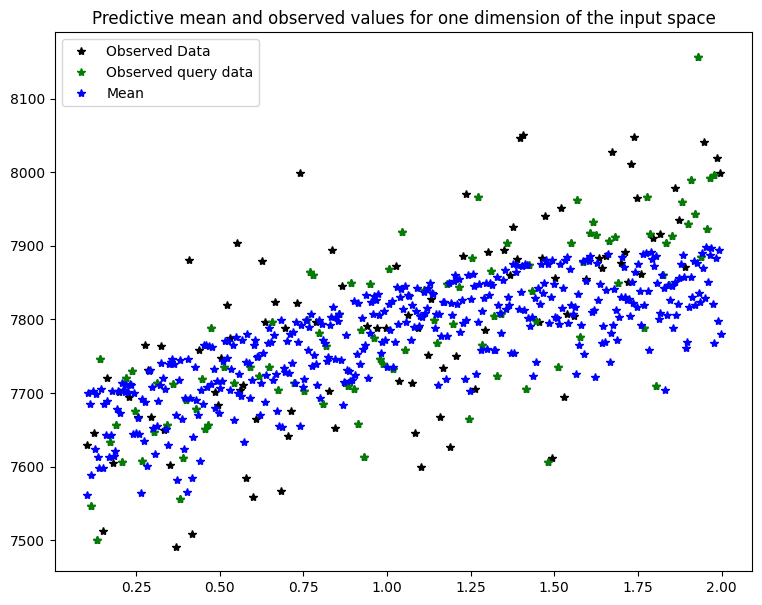

In [36]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(9, 7))
    # Plot training data as black stars
    ax.plot(X_new_labeled.numpy()[:200,2], y_new_labeled.numpy()[:200], 'k*')
    ax.plot(X_new_labeled.numpy()[:100,2], y_new_labeled.numpy()[:100], 'g*')
    # Plot predictive means as blue line
    ax.plot(X_unlabeled.numpy()[:,2], pred_dist.mean.numpy(), 'b*')
    ax.legend(['Observed Data', 'Observed query data', 'Mean'])
    ax.set_title("Predictive mean and observed values for one dimension of the input space")

In [32]:
f.savefig('figure.png')